<a href="https://colab.research.google.com/github/spoupry/Hello-world/blob/main/Fault_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
from pathlib import Path
import os.path
import numpy as np 
import matplotlib.pyplot as plt

import statistics

from google.colab import drive
drive.mount('/content/drive')
dir_path = '/content/drive/My Drive/Colab Notebooks/'
#pour les dates
from datetime import datetime, timedelta
from dateutil.parser import parse

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#chargement du fichier de données
df = pd.read_csv(dir_path + "pm10_daily.csv", delimiter="\t")
#All data in the dataset is in string format. Here we convert them into useful datatypes
df["DateTime"] = pd.to_datetime(df["DateTime"])
df["Arg12b1f"] = pd.to_numeric(df["Arg12b1f"])
df["ENI0122B1V1"] = pd.to_numeric(df["ENI0122B1V1"])
df["ENI0122B2V1"] = pd.to_numeric(df["ENI0122B2V1"])
df.head(2)


,DateTime,Arg12b1f,ENI0122B1V1,ENI0122B2V1
0,2022-03-02 08:22:00,NaN,35.7,42.8
1,2022-03-02 08:22:00,36.2,NaN,NaN


In [ ]:
#Setting the timestamp as index of the dataframe. 
#THis helps to iterate through the data based on time
df.set_index('DateTime', inplace=True)
#We see that DateTime is now the index. It is no longer an ordinary column
#add columns
df["SmS1"] = '' 
df["SmS2"] = '' 
df["SmS3"] = '' 

df.head(2)

,Arg12b1f,ENI0122B1V1,ENI0122B2V1,SmS1,SmS2,SmS3
DateTime,,,,,,
2022-03-02 08:22:00,NaN,35.7,42.8,,,
2022-03-02 08:22:00,36.2,NaN,NaN,,,


In [ ]:
#opération sur le temps
#Testing ig we can do mathematical operations to the timestamp. It works.
StartTime_df = df.index[0]
EndTime_df = df.index[-1]
StepTime = StartTime_df + timedelta(minutes=30)
print("debut df",StartTime_df,"end df",EndTime_df,"pas",StepTime)
# initialisation des series speciales
Median = pd.DataFrame([0], index = [StartTime_df], columns=['Median'])
Comment = pd.DataFrame( ['Begin'] , index = [StartTime_df], columns=['Comment'])
Outliers_SmS1 = pd.DataFrame( [0] , index = [StartTime_df], columns=['Out_SmS1'])
Reliable_SmS1 = pd.DataFrame( [0] , index = [StartTime_df], columns=['Rel_SmS1'])

debut df 2022-03-02 08:22:00 end df 2022-03-02 20:18:00 pas 2022-03-02 08:52:00


In [ ]:
##fait des tranches de temsp de 30 minutes
StartTime_df = df.index[0]
EndTime_df = df.index[-1]
Start_step = StartTime_df 
StepTime = StartTime_df + timedelta(minutes=29)
Time_slice_list=[Start_step]
print("Start: ", Start_step, " , End: ", StepTime)
for time, row in df.iterrows():
  if(time <= StepTime):
    This_time = time
    #print(time)  
  if(time > StepTime):
    Start_step = time
    StepTime = time + timedelta(minutes=30)
    Time_slice_list.append(Start_step)
    #Time_slice_list.append(StepTime)
    #print("Start: ", Start_step, " , End: ", StepTime)

#Time_slice_list

Start:  2022-03-02 08:22:00  , End:  2022-03-02 08:51:00


In [ ]:
#df.loc[StartTime:EndTime]
#df.loc['2022-03-02 08:30':'2022-03-02 09:00']

# test de remplissage des lignes sms1

In [ ]:
#on récupère une tranche de 30 min
Start_step = Time_slice_list[0] 
End_step = Start_step + timedelta(minutes=30)
print("slice-start",Start_step,"slice-end",End_step)
df_slice = df.loc[Start_step:End_step].copy()
df_slice.head()

slice-start 2022-03-02 08:22:00 slice-end 2022-03-02 08:52:00


,Arg12b1f,ENI0122B1V1,ENI0122B2V1,SmS1,SmS2,SmS3
DateTime,,,,,,
2022-03-02 08:22:00,NaN,35.7,42.8,,,
2022-03-02 08:22:00,36.2,NaN,NaN,,,
2022-03-02 08:27:00,31.0,29.9,0.0,,,
2022-03-02 08:32:00,20.0,NaN,NaN,,,
2022-03-02 08:32:00,NaN,18.2,NaN,,,


In [ ]:
#une fois la trance obtenue, on va extraire la médiane et les valeurs brutes
row_value_list = [] #stocker les valeur pour calculer la médiane du set
row_sms1 = []
row_idx_1= []       #stocke les valeurs burtes pour futures détections
row_sms2 = []
row_idx_2= [] 
row_sms3 = []
row_idx_3= [] 
for time, row in df_slice.iterrows():

  if(pd.isna(row["Arg12b1f"]) == False ):      #teste si il y a  NaN 
    #row_value_list.append(row["Arg12b1f"])   #stocke dans la liste
    row_sms1.append(row["Arg12b1f"]) 
    row_idx_1.append(time)
    df_slice.loc[time, "SmS1"] = row["Arg12b1f"]      #met la valeur dans la colonne Sms1
  if(pd.isna(row["ENI0122B1V1"]) == False ):
    #row_value_list.append(row["ENI0122B1V1"]) 
    row_sms2.append(row["ENI0122B1V1"]) 
    row_idx_2.append(time)
    df_slice.loc[time, "SmS2"] = row["ENI0122B1V1"]             
  if(pd.isna(row["ENI0122B2V1"]) == False ):
    #row_value_list.append(row["ENI0122B2V1"])
    row_sms3.append(row["ENI0122B2V1"])
    row_idx_3.append(time)
    df_slice.loc[time, "SmS3"] = row["ENI0122B2V1"] 

#Traitements à partir du premier passage
#print(row_sms1,row_sms2,row_sms3)
row_value_list = row_sms1 + row_sms2 + row_sms3
#df_slice
#print(row_value_list)
# on récupère que les valeurs dont on a besoin
df_slice_sorted = df_slice[['SmS1', 'SmS2', 'SmS3']].copy()
#on enlève les doublons
# on supprime les doublon à cause de la clé
df_slice_sorted.drop_duplicates(keep = 'first', inplace=True)
print(df_slice_sorted)



                     SmS1  SmS2  SmS3
DateTime                             
2022-03-02 08:22:00  36.2  35.7  42.8
2022-03-02 08:27:00  31.0  29.9   0.0
2022-03-02 08:32:00  20.0  18.2  24.0
2022-03-02 08:37:00  15.9  18.2  16.2
2022-03-02 08:42:00  15.9  13.9  11.5
2022-03-02 08:47:00  11.0  12.0  12.0
2022-03-02 08:52:00         6.1   7.8


In [ ]:
#concatener series
s1 = pd.Series(['a', 'b'])
s2 = pd.Series(['c', 'd'])
pd.concat([s1, s2])
#convert dataframe to a serie
data = {'Products': ['Computer', 'Printer', 'Tablet', 'Chair', 'Desk']}
df = pd.DataFrame(data, columns = ['Products'])

my_series = df.squeeze()

print(my_series)
print(type(my_series)

6 7 7


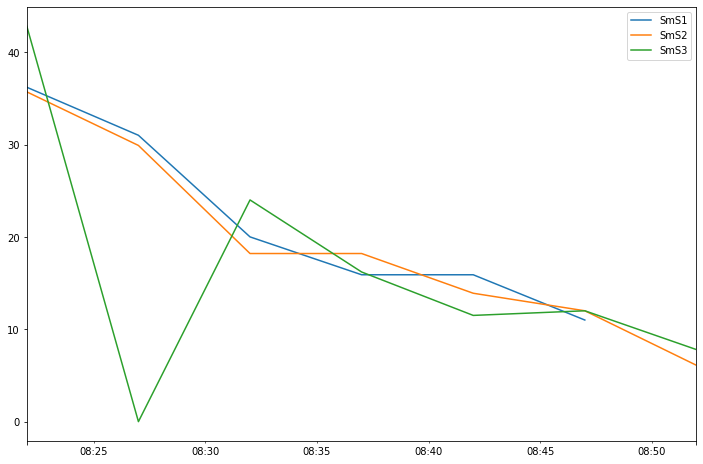

In [ ]:
#création series             
SmS1 = pd.Series(row_sms1, index = row_idx_1)
SmS2 = pd.Series(row_sms2, index = row_idx_2)
SmS3 = pd.Series(row_sms3, index = row_idx_3)
print(len(SmS1),len(SmS2),len(SmS3))
# affichage series
plt.figure(figsize=(12,8))
SmS1.plot(label='SmS1')
SmS2.plot(label='SmS2')
SmS3.plot(label='SmS3')
plt.legend()
plt.show()

In [ ]:
#détection no Data

HardwareFault=[]
print(SmS1.size,SmS2.size,SmS3.size)
if (SmS1.size == 0): 
  #print("Hardware fault SmS1")
  HardwareFault.append("Hardware Fault SmS1")
if (SmS2.size == 0): 
  #print("Hardware fault SmS2")
  HardwareFault.append("Hardware Fault SmS2")
if (SmS3.size == 0): 
  #print("Hardware fault SmS3")
  HardwareFault.append("Hardware Fault SmS3")
  
print(HardwareFault)

#Ajout des Médianes et des commentaires

Comment.loc[End_step,"Comment"] = str(HardwareFault)

print(Comment)

6 7 7
[]
                    Comment
2022-03-02 08:22:00   Begin
2022-03-02 08:52:00      []


In [ ]:
# on va extraire la médiane des valeurs récoltées dans la tranche
#Puis on calcule les seuil Max et Min pour la détection des outliers
liste = [row_value_list]
threshold = 15 # pour 15% d'erreur toléré
Median_slice = np.median(np.array(liste))
MedMin = Median_slice - (Median_slice*threshold)//100
MedMax = Median_slice + (Median_slice*threshold)//100
#on stocke la médiane
Median.loc[End_step, "Median"] = Median_slice
print(Median)
#df_slice_sorted.loc[End_step, "Median"] = Median_slice


                     Median
2022-03-02 08:22:00    0.00
2022-03-02 08:52:00   16.05


In [ ]:
# boucle de détection ( extraction des valeurs outliers)
print("Median",Median_slice,"MedMin",MedMin,"MedMax",MedMax)
print(SmS1)
for time, row in SmS1.iteritems():
   if((row > MedMax) or (row < MedMin)):
     Outliers_SmS1.loc[time, 'Out_SmS1'] = row 
   else:
     Reliable_SmS1.loc[time, 'Rel_SmS1'] = row
print(Reliable_SmS1)
print(Outliers_SmS1)
#Out_max_SmS1 = SmS1[pd.to_numeric(SmS1)>MedMax]
#print(Out_max_SmS1)
#Out_min_SmS1 = SmS1[pd.to_numeric(SmS1)< MedMin]
#print(Out_min_SmS1)
#Outliers_SmS1 = Out_max_SmS1 + Out_min_SmS1
#print(Outliers_SmS1)

Median 16.05 MedMin 14.05 MedMax 18.05
2022-03-02 08:22:00    36.2
2022-03-02 08:27:00    31.0
2022-03-02 08:32:00    20.0
2022-03-02 08:37:00    15.9
2022-03-02 08:42:00    15.9
2022-03-02 08:47:00    11.0
dtype: float64
                     Rel_SmS1
2022-03-02 08:22:00       0.0
2022-03-02 08:37:00      15.9
2022-03-02 08:42:00      15.9
                     Out_SmS1
2022-03-02 08:22:00      36.2
2022-03-02 08:27:00      31.0
2022-03-02 08:32:00      20.0
2022-03-02 08:47:00      11.0


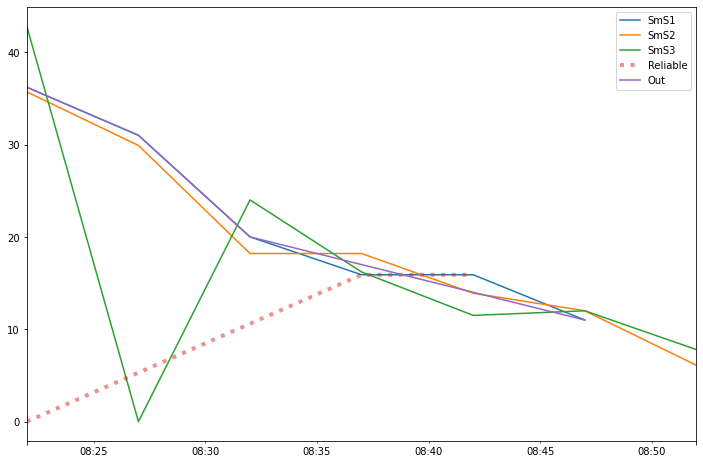

In [ ]:
# affichage series
plt.figure(figsize=(12,8))
SmS1.plot(label='SmS1')
SmS2.plot(label='SmS2')
SmS3.plot(label='SmS3')
#test de convertion df en series
R1 = Reliable_SmS1.squeeze()
R1.plot(label='Reliable', lw=4, ls=':', alpha = 0.5)
Out1 = Outliers_SmS1.squeeze()
Out1.plot(label='Out')
plt.legend()
plt.show()

# opération sur le data frame

In [ ]:
#boucle de détection
print("Median",Median_slice,"MedMin",MedMin,"MedMax",MedMax)
dfss=df_slice_sorted.copy()
#for time, row in dfss.iterrows():
   #if(pd.to_numeric(row["SmS1"]) >= 16.0 ):
     #print("yes")
   #else:
     #print("no")
#avec la librairie pandas
#df_max=pd.to_numeric(dfss['SmS1'])> MedMax 
filtered_max = dfss[pd.to_numeric(dfss['SmS1'])> MedMax ]
print(filtered_max)
df_min=pd.to_numeric(dfss['SmS1'])< MedMin 
filtered_min = dfss[df_min]
print(filtered_min)

#recupere ces valeurs permet de 

Median 16.05 MedMin 14.05 MedMax 18.05
                     SmS1  SmS2  SmS3 Median Out Comments
DateTime                                                 
2022-03-02 08:22:00  36.2  35.7  42.8                    
2022-03-02 08:27:00  31.0  29.9   0.0                    
2022-03-02 08:32:00  20.0  18.2  24.0                    
                     SmS1  SmS2  SmS3 Median Out Comments
DateTime                                                 
2022-03-02 08:47:00  11.0  12.0  12.0                    


# affichage

# test avec le découpage


In [ ]:
StartTime_df = df.index[0]
EndTime_df = df.index[-1]
Start_step = StartTime_df 
StepTime = StartTime_df + timedelta(minutes=29)
Time_slice_list=[Start_step]
print("Start: ", Start_step, " , End: ", StepTime)
for time, row in df.iterrows():
  if(time <= StepTime):
    This_time = time
    #extraction des valeurs
      if(pd.isna(row["Arg12b1f"]) == False ):                #teste si il y a pas de NaN we save that value to a list
      row_value_list.append(row["Arg12b1f"])
      if(pd.isna(row["ENI0122B1V1"]) == False ):
      row_value_list.append(row["ENI0122B1V1"])              #do same for other 2 sensors
      if(pd.isna(row["ENI0122B2V1"]) == False ):
      row_value_list.append(row["ENI0122B2V1"])
    #print(time)  
  if(time > StepTime):
    Start_step = time
    StepTime = time + timedelta(minutes=30)
    Time_slice_list.append(Start_step)